## RC Demo WheatFspm

The goal of this notebook is to devise a suitable **train-test split** for the WheatFspm NEMA simulations as well as apply a **grouping strategy** for the cross-validation folds.

In [158]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

In [159]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

## Loading the dataset

These datasets were collected and converted in the WheatFspm repository.

In [160]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

## Defining targets and observable state variables

These were selected in the previous notebook, `2022_03_23_wheatfspm_dataset_inspection.ipynb`

In [161]:
hydroshoot_inputs = (
  'input_air_temperature', 
  'input_humidity',
  'input_Wind',
  'input_PARi'
)

hydroshoot_outputs = (
  'output__axes__Total_Transpiration',
  'output__axes__C_exudated', 
  'output__axes__SAM_temperature'
)

hydroshoot_state = (
  'state__An',
  'state__Transpiration',
  'state__S_Sucrose',
  'state__Ts',
  'state__gs'
)

exclusive_outputs = (
  'output__axes__delta_teq',
  'output__axes__sum_respi_shoot',
  'output__organ_roots__N_exudation'
)

exclusive_state = (
  'state__Ag',
  'state__Tr',
  'state__sucrose',
  'state__Rd',
  'state__sum_respi',
  'state__Photosynthesis',
  'state__PARa'
)


input_targets = [*hydroshoot_inputs]
output_targets = [*hydroshoot_outputs, *exclusive_outputs]


targets = [*input_targets, *output_targets]
state_variables = [*hydroshoot_state, *exclusive_state]




print(f'Targets:')
for target in targets:
  print(f'\t- {target}')

print(f'\nState variables:')
for state_var in state_variables:
  print(f'\t- {state_var}')

Targets:
	- input_air_temperature
	- input_humidity
	- input_Wind
	- input_PARi
	- output__axes__Total_Transpiration
	- output__axes__C_exudated
	- output__axes__SAM_temperature
	- output__axes__delta_teq
	- output__axes__sum_respi_shoot
	- output__organ_roots__N_exudation

State variables:
	- state__An
	- state__Transpiration
	- state__S_Sucrose
	- state__Ts
	- state__gs
	- state__Ag
	- state__Tr
	- state__sucrose
	- state__Rd
	- state__sum_respi
	- state__Photosynthesis
	- state__PARa


The target data can be generated in the same way as the code used for HydroShoot:

In [162]:
# There is an apparent regime change after some time step (see daily notes 2022-03-25).
# To enforce pseudo-stationarity of the reservoir dynamics we will limit the used data
# to the simulation steps before the regime change.

max_time_step = {
    "NEMA_H0": 696,  # originally 696
    "NEMA_H3": 864 - 24,  # originally 864
    "NEMA_H15": 912 - 24,  # originally 912
}

In [163]:
def direct_target_generator(dataset: ExperimentDataset, target: str, run_id):
    """Returns a generator that generates the target from the run id."""
    assert target in dataset.get_targets(), f"{target} not available in dataset."
    yield dataset.get_target(target, run_id).to_numpy()[:max_time_step[run_id]]


target_gen = direct_target_generator(dataset_nema_h3, targets[0], 'NEMA_H3')

print(next(target_gen).shape)

(840,)


Not every observed node has a value for the given state variable (e.g. difference between stem vs leaf).

To generate the reservoir time series, we need to filter out the NaN states.

In [164]:
def direct_reservoir_generator(dataset, state_var: str, run_id):
    """Returns a function that generates the reservoir from the run id."""
    assert (
        state_var in dataset.get_state_variables()
    ), f"{state_var} not available in dataset."

    state = dataset.get_state(state_var, run_id)[: max_time_step[run_id]]

    state_NaN = np.isnan(state)
    NaN_idx = np.any(state_NaN, axis=0)

    state_null = np.isclose(state, 0)
    null_idx = np.all(state_null, axis=0)

    state = state[:, ~NaN_idx & ~null_idx]

    yield state


state_gen = direct_reservoir_generator(dataset_nema_h3, state_variables[0], 'NEMA_H3')
print(next(state_gen).shape)

(840, 10)


## Data preprocessing

Preprocessing performed:

1. ~~A random subsample of observation nodes is selected.~~ for now, no subsampling (the state is already small!)
2. The target signal for each run is computed.
3. Target and reservoir are cast into a ndarray.
4. Target and reservoir signals are trimmed.
   - A warmup mask is applied to target and reservoir.
   - A night-time mask is applied to target and reservoir.
5. Target and reservoir are rescaled to zero-mean and unit variance
   - Normalizing transform is fitted on the entire dataset of included experiment runs.

In [165]:
import warnings

def preprocess_data(dataset, target, reservoir, warmup_steps=0, day_mask=None):
  """
  Preprocessing performed:

  1. The target signal for each run is computed.
  2. Target and reservoir are cast into a ndarray.
  3. Target and reservoir signals are trimmed.
    - A warmup mask is applied to target and reservoir.
    - A night-time mask is applied to target and reservoir.
  4. Target and reservoir are rescaled to zero-mean and unit variance
    - Normalizing transform is fitted on the entire dataset of included experiment runs.
  """

  # 1. Cast target and reservoir state into NumPy ndarrays.
  # first dimension is run_id, for compatibility with HydroShoot code
  X = np.empty((1, *reservoir.shape))  # shape (n_runs, time_steps, nodes)
  y = np.empty((1, *target.shape))  # shape (n_runs, time_steps)

  X[0, :, :] = reservoir
  y[0, :] = target

  # 3. Masks are applied.
  if day_mask is None:
      time_mask = np.ones(X.shape[1], dtype=bool)
  else:
      n_days = X.shape[1] // len(day_mask)
      # try:
      #     assert (
      #         dataset.n_steps() % len(day_mask) == 0
      #     ), "Dataset time steps must be multiple of day mask."
      # except:
      #     warnings.warn("Dataset time steps is not a multiple of day mask!")
      time_mask = np.tile(day_mask, n_days)

  time_mask[:warmup_steps] = False
  X = X[:, time_mask, :]
  y = y[:, time_mask]

  # 4. Normalize target and reservoir states
  X = (X - X.mean()) / X.std()
  y = (y - y.mean()) / y.std()

  return X, y


In [174]:
from src.learning.preprocessing import generate_mask


# DATASET = dataset_nema_h3
# RUN_ID = 'NEMA_H3'
DATASET = dataset_nema_h0
RUN_ID = 'NEMA_H0'

# TARGET = 'input_humidity' 
# STATE_VAR = 'state__Ts'
TARGET = targets[0]
STATE_VAR = state_variables[0]

WARMUP_STEPS = 4 * 24
DAY_MASK = generate_mask(5, 21)


target = next(direct_target_generator(DATASET, TARGET, RUN_ID))
reservoir = next(direct_reservoir_generator(DATASET, STATE_VAR, RUN_ID))
X_raw, y_raw = preprocess_data(DATASET, target, reservoir, WARMUP_STEPS, DAY_MASK)

print(X_raw.shape)
print(y_raw.shape)        

(1, 400, 10)
(1, 400)


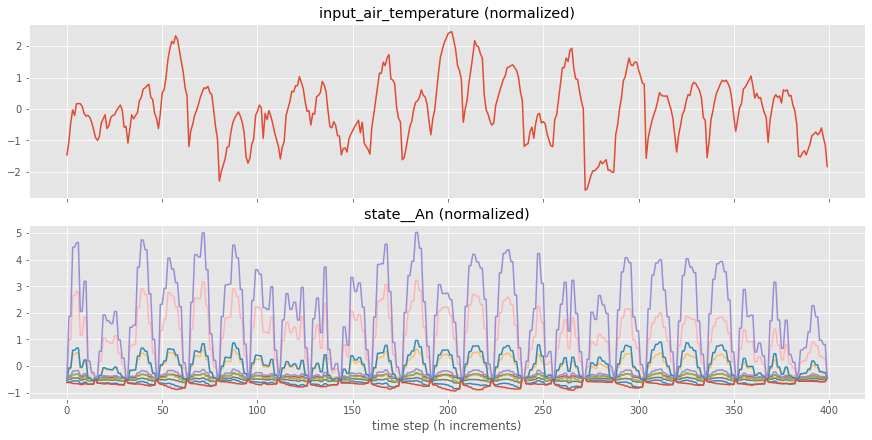

In [175]:
with plt.style.context('ggplot'):
  fig, (ax_target, ax_reservoir) = plt.subplots(2, 1, figsize=(12, 6), constrained_layout=True, sharex=True)

  ax_target.plot(y_raw[0, :])
  ax_target.set_title(f'{TARGET} (normalized)')

  ax_reservoir.plot(X_raw[0, :, :])
  ax_reservoir.set_title(f'{STATE_VAR} (normalized)')
  ax_reservoir.set_xlabel('time step (h increments)')

  plt.show()

## Grouping

Grouping will be done on a calendar day basis. This is simpler than with the HydroShoot dataset because it is a single stream of data rather than multiple overlapping runs.

```
GROUP 1 | GROUP 2 | GROUP 3 | GROUP 4 | ...
--------+---------+---------+---------+----
sim/d1   sim/d2    sim/d3    sim/d4     ...
```

In [176]:
X = X_raw[0, :, :]
y = y_raw[0, :]

print(X.shape)
print(y.shape)        

(400, 10)
(400,)


In [177]:
def group_by_day(X: np.ndarray, day_mask: np.ndarray) -> np.ndarray:
  day_length = day_mask.sum()
  assert len(X) % day_length == 0, "X must have multiple of day_mask time steps."

  n_groups = len(X) // day_length

  groups = np.arange(n_groups).repeat(day_length)
  return groups

In [178]:
X = X_raw[0, :, :]
y = y_raw[0, :]
groups = group_by_day(X, DAY_MASK)

print(X.shape)
print(y.shape)     
print(groups.shape)     
print(f'{len(np.unique(groups))} groups')

(400, 10)
(400,)
(400,)
25 groups


## Train-test splitting

Train-test splitting is done at group scope (i.e. per simulated 24h day-night cycle).

**Splitting strategy:** alternating training and testing dates.

```
g1     g2      g3      g4      g5      g6      g7     g8                   
------+-------+-------+-------+-------+-------+-------+-------+
Train | Test  | Train | Test  | Train | Test  | Train | Test  | ... (repeat)
```


In [179]:
def train_test_split_alternating(X, y, groups, ratio=1, blocks=1):
  """The ratio parameter determines how many training days 
  are included for every test day.
  
  e.g. if ratio=2, then the train-test ratio is 2:1
  """
  group_ids = np.unique(groups)

  train_groups_mask = np.ones((ratio + 1), dtype=bool)
  train_groups_mask[-1] = False
  train_groups_mask = np.repeat(train_groups_mask, blocks)
  train_groups_mask = np.tile(
      train_groups_mask, np.ceil(len(group_ids) / len(train_groups_mask)).astype(int)
  )
  train_groups_mask = train_groups_mask[: len(group_ids)]
  train_group_ids = group_ids[train_groups_mask]
  train_mask = np.isin(groups, train_group_ids)

  X_train = X[train_mask]
  groups_train = groups[train_mask]
  y_train = y[train_mask]

  X_test = X[~train_mask]
  y_test = y[~train_mask]
  groups_test = groups[~train_mask]

  return (X_train, y_train, groups_train), (X_test, y_test, groups_test)



In [205]:
# train, test = train_test_split_alternating(X, y, groups)
train, test = train_test_split_alternating(X, y, groups, ratio=1, blocks=4)

X_train, y_train, groups_train = train
X_test, y_test, groups_test = test

print(f'X_train shape:      {X_train.shape}')
print(f'y_train shape:      {y_train.shape}')
print(f'groups_train shape: {groups_train.shape}')
print(f'X_test shape:       {X_test.shape}')
print(f'y_test shape:       {y_test.shape}')
print(f'groups_train shape: {groups_train.shape}')

print(f'Training groups: {np.unique(groups_train).shape[0]}')
print(f'Testing groups: {np.unique(groups_test).shape[0]}')

X_train shape:      (208, 10)
y_train shape:      (208,)
groups_train shape: (208,)
X_test shape:       (192, 10)
y_test shape:       (192,)
groups_train shape: (208,)
Training groups: 13
Testing groups: 12


## Model definition

We start with a standard linear model:

- Readout model is a standard RidgeRegression model with intercept term and CV-tuned regularization strength $\alpha$.
- CV search grid is a progression of logarithmicly spaced values for regularization strength $\alpha$.
- CV and testing metric is NMSE.

In [206]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

from src.learning.scorers import nmse_scorer


N_FOLDS = np.unique(groups_train).shape[0]
# N_FOLDS = 5


# Define model
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

# define search grid
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)
}]

# define cross-validation and testing metric
scorer = nmse_scorer

# Define CV fold strategy
folds = GroupKFold(n_splits=N_FOLDS)

## Readout training and evaluation

Regularization strength is tuned using a grid search.

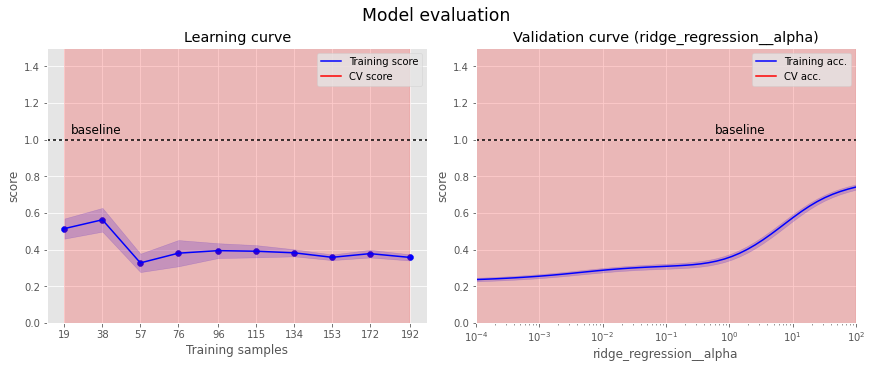

In [207]:
%reload_ext autoreload
%autoreload 2 

from figures import learning_validation_curves

param_name = 'ridge_regression__alpha'
param_range = 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)

learning_validation_curves(readout, X_train, y_train, groups_train, folds, scorer, param_name, param_range)

In [208]:
from src.learning.training import perform_gridsearch

model, _ = perform_gridsearch(readout, X_train, y_train, groups_train, folds, search_grid, verbose=True)

test_score = -scorer(model, X_test, y_test)
print(f'\nNMSE on test set: {test_score:.4f}')

Cross-validation scores after tuning:
  - Train: -0.2464 +/- 0.01042
  - CV:    -2.2802 +/- 4.95018
Optimal hyperparameters:
  - ridge_regression__alpha = 0.00040949150623804275

NMSE on test set: 0.3753


Train a final model on the optimal ridge regression parameter:

In [209]:
best_alpha = model.best_estimator_.get_params()['ridge_regression__alpha']

final_model = Pipeline([
  ('ridge_regression', Ridge(alpha=best_alpha, fit_intercept=True))
])

final_model.fit(X_train, y_train)

final_score = -scorer(final_model, X_test[:], y_test[:])

print(f'Predicting "{TARGET}" from "{STATE_VAR}":')
print(f'\tNMSE on test set: {final_score:.4f}')

Predicting "input_air_temperature" from "state__An":
	NMSE on test set: 0.3753


C:\Users\Max\AppData\Local\Temp/ipykernel_8504/3742208684.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([f'day {i}' for i in np.arange(0, day_count)])
C:\Users\Max\AppData\Local\Temp/ipykernel_8504/3742208684.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f'day {i}' for i in np.arange(0, day_count)])


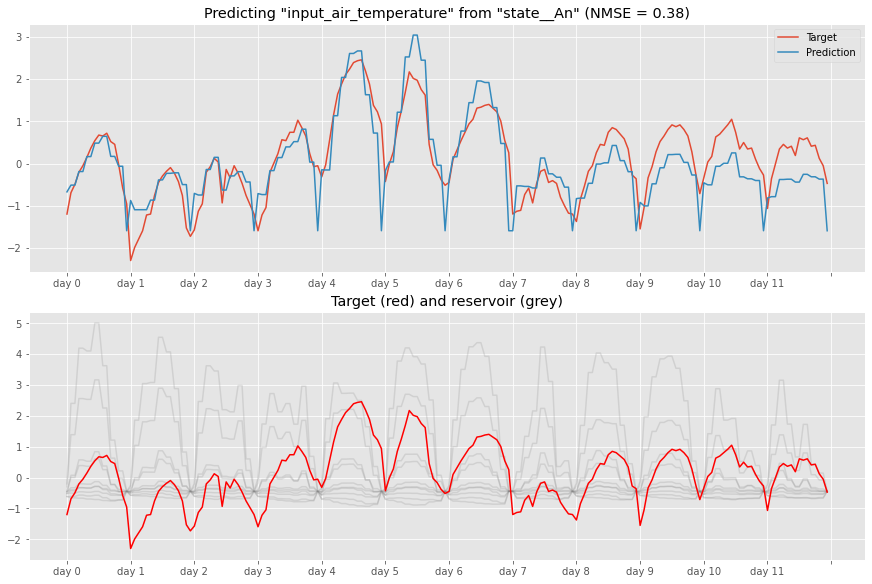

In [210]:
y_hat = final_model.predict(X_test)

with plt.style.context('ggplot'):
  fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

  mask_length = DAY_MASK.sum()
  day_count = len(y_test) // mask_length

  series_mask = np.tile(DAY_MASK, day_count)

  # y_test_plot = np.empty((day_count * 24,))
  # y_pred_plot = np.empty((day_count * 24,))

  # y_test_plot[series_mask] = y_test
  # y_test_plot[~series_mask] = None
  # y_pred_plot[series_mask] = y_hat
  # y_pred_plot[~series_mask] = None

  y_test_plot = y_test[:]
  y_pred_plot = y_hat[:]

  ax0.plot(y_test_plot, label='Target')
  ax0.plot(y_pred_plot, label='Prediction')

  ax0.set_xticklabels([f'day {i}' for i in np.arange(0, day_count)])
  ax0.set_xticks(np.arange(0, len(y_test_plot) + mask_length, mask_length))

  ax0.set_title(f'Predicting "{TARGET}" from "{STATE_VAR}" (NMSE = {final_score:.2f})')
  # ax0.set_xlabel('Time step (h increments)')
  ax0.legend(loc='best')

  ax1.plot(X_test, alpha=0.2, color='grey')
  ax1.plot(y_test, color='red')
  ax1.set_xticklabels([f'day {i}' for i in np.arange(0, day_count)])
  ax1.set_xticks(np.arange(0, len(y_test_plot) + mask_length, mask_length))
  ax1.set_title('Target (red) and reservoir (grey)')

  plt.show()